### Assignment 1
Yorick Juffer \
s1993623

This script aims to emulate the results found by Grosjean et al. which saught to test the hypothesis that people use an internal timekeeper. This was done in a three serial choice reaction time task, where participants were shown a stimulus and asked to react. In the last trial, the stimulus would arrive later or eariler then expected. Results showed that participant's final reaction time was significantly slower when first exposed to 700ms stimulus interval and 0.467ms in the last trial, and faster when first exposed to a 0.350ms stimulus interval and 0.467ms in the last trial.

To emulate these results, a few functions are utilised which are discussed below. 

**Libraries**

In [2]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Noise** \
First, a noise function is included to add some variation to the system. It is clear that humans are quite variable, however this is not the case for computers so this variation needs to be enforced to make the system more believable.

In [3]:
def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

**Time to Pulses** \
Second, a time to pulses function is used to translate experienced time into pulses, which represent the internal timekeeper. When translating, some noise is added to increase the variability. This function is sourced from the lecture slides, however the “t_1” and “a” parameters were changed to 100ms and 1.02 respectively. This aligned the final product closer to the results of the paper. 

In [4]:
def time_to_pulses(time, t_0 = 0.1, a = 1.02, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

**Pulses to Time** \
Third, a pulses to time function is used to translate pulses back to time. This is used when a comparision needs to be made between the internal time keeper and the actual time of the stimulus. Again, some variation is added to better reflect reality and the parameter values were also changed.

In [5]:
def pulses_to_time(pulses, t_0 = 0.1, a = 1.02, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

**Reaction Time Experiment** \
For the actual experiment, the reaction function is used. It is called with the stimulus interval (0.350s, 0.467s, 0.700s) and is currently set up to run 24 participants, with 6 training blocks and 10 trial blocks. These parameters are similar as used in the actual experiment. Each participant undergoes training whereby the stimulus is shown so that the internal timekeeper can be tuned using a running average. This part is not strictly necessary for a computer, but I choose to include it to keep parity with the paper. After this, the trial block starts where an estimation is made based on the timekeeper. If the guess is before the appearance of the stimulus, then the participant is "prepared" and their reaction time is up to 0.05s faster than if the guess is after the stimulus. As general reaction time is difficult to implement into a simple script like this, it is hardcoded to be 0.410s based on the results of the original paper. During the training block, learning continues and the internal timekeeper is tuned each iteration. In the last trial, the stimulus is shown at 0.467 seconds.

<AxesSubplot: ylabel='average'>

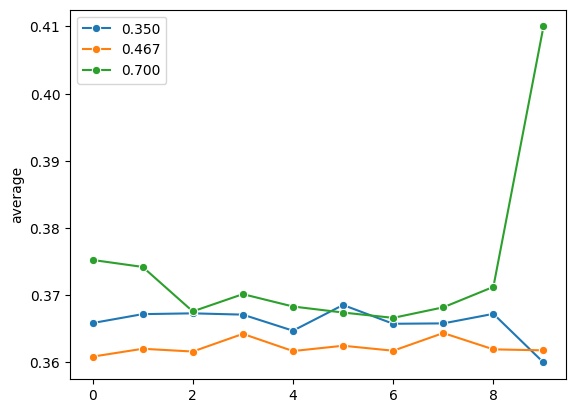

In [66]:
def reaction(condition, participants = 24, training = 6, trials = 10):
    results = pd.DataFrame(index=range(trials), columns=range(participants))

    # keeps track of the original condition time
    condition_saved = condition

    for participant in range(participants):

        # reset variables for the next participant. 
        memory = 0
        condition = condition_saved       

        # train
        for i in range(training):
            memory += time_to_pulses(condition)
        memory = memory / training
        
        # trials
        for trial in range(trials):

            reaction_time = 0.410

            if(trial == trials - 1):
                condition_saved = condition
                condition =  0.467

            # the difference between the observed stimulus time, and the expected timing based on memory. 
            difference = condition - pulses_to_time(memory)

            if(difference >= 0.05):
                reaction_time =  reaction_time - 0.05
            elif(difference <= 0):
                reaction_time =  reaction_time
            else: 
                reaction_time =  reaction_time - difference

            # continues to learn. It's divided by 2.01 to counteract a bias introduced by the time_to_pulses function which causes RT to slowly creep up. 
            # to view this bias, set the division = 2, and trials = 100
            memory = (memory + time_to_pulses(condition))/2.01

            results.at[trial, participant] = reaction_time
            results["average"] = results.mean(axis=1)

    return results["average"]



result_350 = reaction(0.350)
result_467 = reaction(0.467)
result_700 = reaction(0.700)

sns.lineplot(data=result_350, label="0.350", marker="o")
sns.lineplot(data=result_467, label="0.467", marker="o")
sns.lineplot(data=result_700, label="0.700", marker="o")


The results of this script are similar to the findings of the original paper. The 0.700s condition sprikes and the 0.350s condition decreases in the last trial. As expected the 0.467s condition remains stable. One issue found was a bias introduced by the time/pulse functions, whereby after translating from time to pulse, and back from pulse to time, the time would be underestimated slightly. This bias impacted the 0.700s condition such that the reaction time would slowly creep up. In the training block, this was remedied by dividing by 2.01 rather than 2.